# Galactic Astrophysics Notebook

## Part 2: Classification of galaxy morphology

The Galaxy Zoo Project 2 classfied around 200,000 galaxy images obtained from the Sloan Digital Sky Survey (SDSS), DR7 and other similar surveys. The images are classified into 37 categories following a set of 11 questions with the help of the public (citizen scientists).

For these tasks, we will use a subset of the Galaxy Zoo dataset consisting of 10,000 galaxy images in the training dataset and 2000 images for the test dataset.

Please download the main folder from here: https://drive.google.com/file/d/1IZm7C4KbJnAQfxBwkiXLAKf5P-CbR0-x/view?usp=sharing

(Note that this is almost 200MB)

These are the modules that you will need:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Now you shold set up the path to your data, this depends on where you saved it. 
Please set a path for 

main folder (galaxy-zoo-small)

The training images (images_train_small)

The labels (train_labels_small.csv)

Then save the labels in a dataframe using pandas. 

In [3]:
data_dir = "galaxy-zoo-small"
images_dir = "galaxy-zoo-small/images_train_small"
labels_csv = "galaxy-zoo-small/train_labels_small.csv"

labels_df = pd.read_csv(labels_csv).set_index("GalaxyID") 

It is a good idea to confirm the number of images in the dataset to check it is what you expect

In [4]:


# Make sure images_dir is already defined
# e.g. images_dir = os.path.join(data_dir, "images_training_rev1")

# Get a list of all image files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Count them
num_images = len(image_files)

print(f"Total number of galaxy images found: {num_images:,}")

# Show a few example filenames
print("Sample image files:", image_files[:5])


Total number of galaxy images found: 10,000
Sample image files: ['139923.jpg', '704147.jpg', '612731.jpg', '720797.jpg', '823863.jpg']


Now we need to label each galaxy so that we can train the CNN with data that it knows the answer to

The galaxies in galaxy zoo do not have strict labels, they have probabilites. You can read about this here: 

www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/overview/the-galaxy-zoo-decision-tree

Print out the first few rows of the dataframe containing the probabilies:


In [5]:
labels_df.head(10)

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,
100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.000000,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0000,0.000000
100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
100322,0.091987,0.908013,0.000000,0.816806,0.091207,0.000000,0.091207,0.000000,0.091207,0.044669,...,0.142815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
100380,0.030000,0.970000,0.000000,0.043650,0.926350,0.463175,0.463175,0.926350,0.000000,0.000000,...,0.027456,0.463175,0.463175,0.000000,0.000000,0.272619,0.136310,0.272619,0.0816,0.163201
100867,0.806776,0.143003,0.050220,0.000000,0.143003,0.000000,0.143003,0.000000,0.143003,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
100887,0.548984,0.430549,0.020467,0.000000,0.430549,0.280732,0.149817,0.330202,0.100347,0.051770,...,0.000000,0.165101,0.165101,0.000000,0.000000,0.165101,0.000000,0.000000,0.0000,0.165101
101007,0.077166,0.895607,0.027227,0.000000,0.895607,0.147039,0.748568,0.742200,0.153407,0.000000,...,0.000000,0.480423,0.210207,0.051571,0.000000,0.030076,0.296901,0.000000,0.0000,0.415223
101251,0.722908,0.252678,0.024414,0.000000,0.252678,0.000000,0.252678,0.252678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.252678,0.252678,0.000000,0.000000,0.000000,0.0000,0.000000
101283,0.576192,0.423808,0.000000,0.000000,0.423808,0.183939,0.239869,0.179203,0.244605,0.000000,...,0.000000,0.179203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.179203


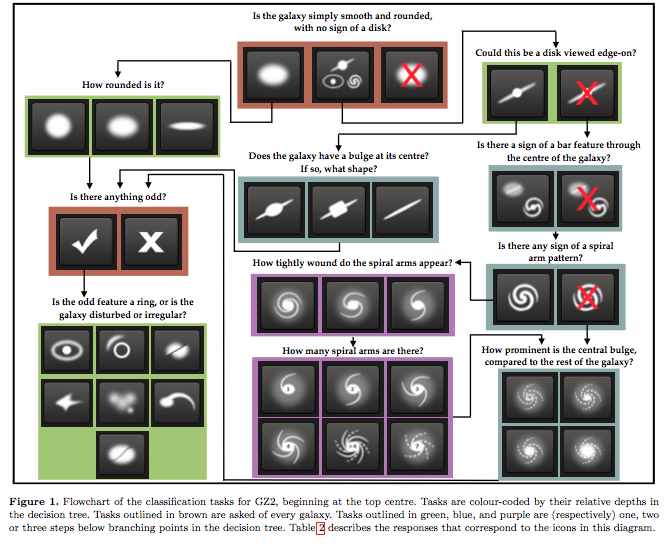

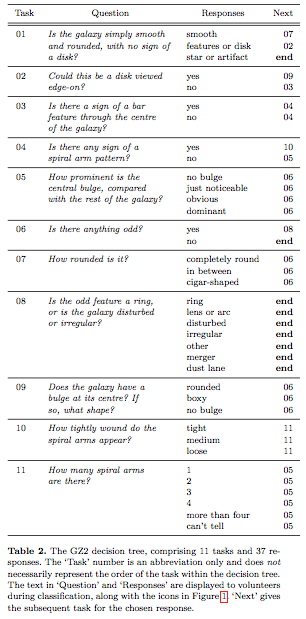

In [6]:
from IPython.display import Image, display
display(Image(filename='figure1.png', width=600))
display(Image(filename='table2.png', width=600))

You can see how the classes match up to the questions in the table (and so the images in the first figure here).

For your first attempt as classification, lets take class 1.2 (corresponding to task 01 'features or disk' and the middle image in the first section of the flow chart) to be sprial. For elliptical, lets choose class 1.1 (corresponding to task 01 'smooth' and the left image in the first section of the flow chart).

To narrow down the images, choose a probabiltiy of above 0.8 for each class from the dataframe, then we will give this the label 'spiral' (1) or 'elliptical' (2).


In [7]:
# Spiral if Class1.2 > 0.8
spirals = labels_df[labels_df["Class1.2"] > 0.8].copy()
spirals["label"] = 1

# Elliptical if Class1.1 > 0.8
ellipticals = labels_df[labels_df["Class1.1"] > 0.8].copy()
ellipticals["label"] = 0


Print out how many there of each

In [8]:
print("Strict spirals:", len(spirals))
print("Strict ellipticals:", len(ellipticals))

Strict spirals: 2615
Strict ellipticals: 1308


With CNNs it is important for the dataset to be balanced so that it can learn from each type of image. 
You should see from the numbers that you have just printed out that it is unbalanced. 

Choose a random sample of 500 from each type to save for training of the model (lets start small, you can increase this later if you want to). 

In [9]:
# Balance the dataset (equal numbers from both groups)
n = min(len(spirals), len(ellipticals), 1000)  # cap at 500 each
balanced = pd.concat([
    spirals.sample(n, random_state=42),
    ellipticals.sample(n, random_state=42)
])
print("Balanced dataset:", balanced["label"].value_counts())

Balanced dataset: 1    1000
0    1000
Name: label, dtype: int64


Here is some code to show some of the images, you can explore this

Example Spiral Galaxies:


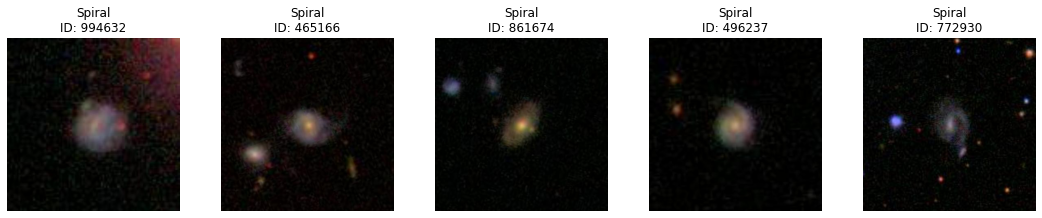

Example Elliptical Galaxies:


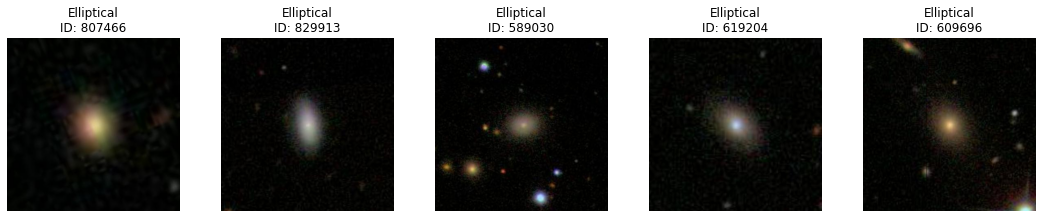

In [122]:
from PIL import Image
def show_examples(df, images_dir, label_name, n=5):
    sample = df.sample(n, random_state=42)
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i, (galaxy_id, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(images_dir, f"{galaxy_id}.jpg")
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            axs[i].axis("off")
            continue
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].set_title(f"{label_name}\nID: {galaxy_id}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

print("Example Spiral Galaxies:")
show_examples(spirals, images_dir, "Spiral", n=5)

print("Example Elliptical Galaxies:")
show_examples(ellipticals, images_dir, "Elliptical", n=5)


This part of the code tells PyTorch how to read each galaxy image, convert to grayscale, resize, and return with its label.

In [123]:
class GalaxyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        galaxy_id = self.df.index[idx]
        label = int(self.df.iloc[idx]["label"])
        img_path = os.path.join(self.img_dir, f"{galaxy_id}.jpg")
        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)
        return img, label


5. Data transforms & loaders
Resizes to 64×64 pixels, converts to tensor.
Splits dataset into 80% train, 20% test.
Loads in mini-batches of 32 galaxies.

In [124]:
# -------------------
# 5. Data transforms
# -------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = GalaxyDataset(balanced, images_dir, transform=transform)

# Train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

6. CNN
Conv1 → finds edges.
Conv2 → finds bigger shapes.
FC1/FC2 → final decision: spiral or elliptical.

In [125]:
# -------------------
# 6. Simple CNN
# -------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

7. Training
For each epoch:
Show galaxy batch to CNN.
Compute error.
Update weights (learn).

In [10]:
# -------------------
# 7. Training loop
# -------------------
for epoch in range(10):  # try 10–20 for better results
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

NameError: name 'model' is not defined

8. Evaluation
Test accuracy.
Confusion matrix to see per-class results.

Test Accuracy: 0.58


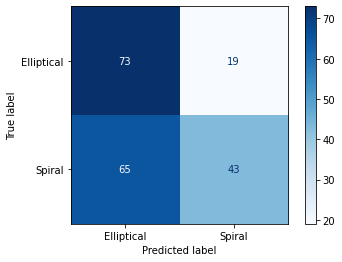

In [127]:
# -------------------
# 8. Evaluation + Confusion Matrix
# -------------------
model.eval()
all_preds = []
all_labels = []
all_imgs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        all_imgs.extend(imgs.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_imgs = np.array(all_imgs)

# Accuracy
accuracy = (all_preds == all_labels).mean()
print("Test Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Elliptical", "Spiral"])
disp.plot(cmap="Blues", values_format="d")
plt.show()

Show examples
Top row = correct predictions.

Bottom row = mistakes (misclassifications).
You can see real galaxies and how the CNN did.

Correct examples: 116
Misclassified examples: 84


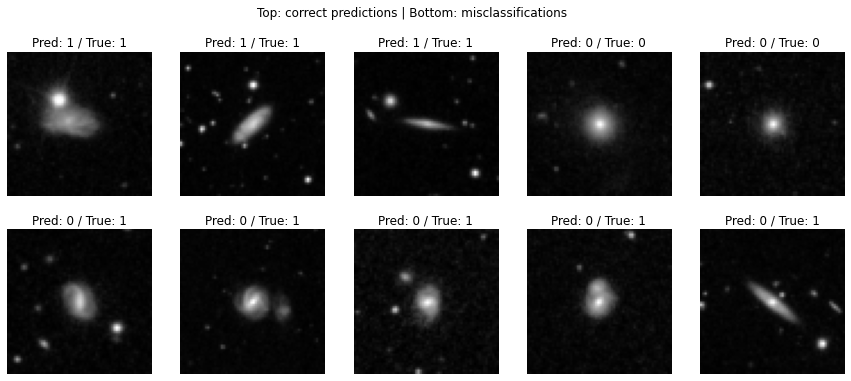

In [128]:
# -------------------
# 9. Show correct vs misclassified examples
# -------------------
correct_idx = np.where(all_preds == all_labels)[0]
incorrect_idx = np.where(all_preds != all_labels)[0]

print("Correct examples:", len(correct_idx))
print("Misclassified examples:", len(incorrect_idx))

num_show = 5
fig, axs = plt.subplots(2, num_show, figsize=(15, 6))

# Top row: correct
for i in range(num_show):
    if i < len(correct_idx):
        idx = correct_idx[i]
        axs[0, i].imshow(all_imgs[idx][0], cmap="gray")
        axs[0, i].set_title(f"Pred: {all_preds[idx]} / True: {all_labels[idx]}")
        axs[0, i].axis("off")

# Bottom row: misclassified
for i in range(num_show):
    if i < len(incorrect_idx):
        idx = incorrect_idx[i]
        axs[1, i].imshow(all_imgs[idx][0], cmap="gray")
        axs[1, i].set_title(f"Pred: {all_preds[idx]} / True: {all_labels[idx]}")
        axs[1, i].axis("off")

plt.suptitle("Top: correct predictions | Bottom: misclassifications")
plt.show()